

```
# This is formatted as code
```

### WebNLG Challenge 2023¶

The WebNLG challenge consists in mapping data to text. For instance, given the 3 DBpedia triples shown in (a), the aim is to generate a text such as (b).

a. (John_E_Blaha birthDate 1942_08_26) (John_E_Blaha birthPlace San_Antonio) (John_E_Blaha occupation Fighter_pilot)
b. John E Blaha, born in San Antonio on 1942-08-26, worked as a fighter pilot.

More info: https://synalp.gitlabpages.inria.fr/webnlg-challenge/

Link to this colab file: https://drive.google.com/file/d/1evGzcuSOTtxoFguQiJHFLFfyQDze5mK3/view?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install sentencepiece
!pip install transformers
!pip install timm

In [ ]:
import gc
import pandas as pd
import numpy as np
import os
import torch
import glob
import pathlib
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers.optimization import  Adafactor 
import time
import warnings
import math
warnings.filterwarnings('ignore')
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
nltk.download('punkt')

root = '/content/drive/My Drive/webNLG/project/'
root_xml_data = 'xml_data/'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
if torch.cuda.is_available():
   dev = torch.device("cuda:0")
   print("Running on the GPU")
else:
   dev = torch.device("cpu")
   print("Running on the CPU")

Running on the GPU


# **Setting up the dataset**

First convert the .xml file to csv

In [ ]:
import subprocess
import os

os.makedirs(root + 'csv_data/train', exist_ok=True)
os.makedirs(root + 'csv_data/dev', exist_ok=True)
os.makedirs(root + 'csv_data/test', exist_ok=True)

dataset_names = [
    'University', 'Airport', 'Astronaut', 'Building', 'City', 'ComicsCharacter', 
    'Food', 'Monument', 'SportsTeam', 'WrittenWork']

for name in dataset_names:
  train_path = os.path.join(root, root_xml_data, f'{name}.xml')
  train_path_csv = os.path.join(root, f'csv_data/train/{name}.csv')

  dev_path = os.path.join(root, root_xml_data, f'dev/{name}_dev.xml')
  dev_path_csv = os.path.join(root, f'csv_data/dev/{name}_dev.csv')

  test_path = os.path.join(root, root_xml_data, f'test/{name}_test.xml')
  test_path_csv = os.path.join(root, f'csv_data/test/{name}_test.csv')

  # Run the XML to CSV conversion script using subprocess
  subprocess.run(['python', '/content/drive/MyDrive/webNLG/project/xml_data/xml-csv_script.py', train_path, train_path_csv])
  subprocess.run(['python', '/content/drive/MyDrive/webNLG/project/xml_data/xml-csv_script.py', dev_path, dev_path_csv])
  subprocess.run(['python', '/content/drive/MyDrive/webNLG/project/xml_data/xml-csv_script.py', test_path, test_path_csv])

This code below combines multiple CSV files into a single CSV file by concatenating them into a single DataFrame and then saving it as a new file, excluding the 'prefix' column.

In [ ]:
root = root + 'csv_data/'

def combine_train_dev(root, files_path, new_file):
  path_to_csv_files = glob.glob(root + files_path);

  # Read each CSV file into a DataFrame and this creates a list of dataframes
  data_list = (pd.read_csv(file) for file in path_to_csv_files);

  # Concatenate all DataFrames
  all_data  = pd.concat(data_list, ignore_index=True);
  all_data.drop('prefix', inplace=True, axis=1)
  all_data.to_csv(root + f"{new_file}.csv", index=False) #save to new csv file

In [ ]:
combine_train_dev(root, 'train/*.csv', 'train/train') #for train.csv files
combine_train_dev(root, 'dev/*.csv', 'dev/dev') #for dev.csv files

In [ ]:
train_data = pd.read_csv(root +'train/train.csv');
dev_data = pd.read_csv(root +'dev/dev.csv');

train_data.head()

,input_text,target_text
0,['1_Decembrie_1918_University | city | Alba_Iu...,"['The ""1 Decembrie 1918 University"" is in the ..."
1,['1_Decembrie_1918_University | country | Roma...,['The 1 Decembrie 1918 University is located i...
2,"['1_Decembrie_1918_University | latinName | ""U...",['The Latin name of the 1 Decembrie 1918 Unive...
3,['1_Decembrie_1918_University | nickname | Uab'],['The 1 Decembrie 1918 University has the nick...
4,"['1_Decembrie_1918_University | rector | ""Brea...",['Breaz Valer Daniel is rector of the 1 Decemb...


## **Text Preprocessing**

1. Include a space in all joined letters like latinName = latin Name

In [ ]:
def process_csv_file(input_file_path, output_file_path):
    data = pd.read_csv(input_file_path)
    data['input_text'] = data['input_text'].astype(str)
    for index, row in data.iterrows():
        input_text = row['input_text']
        input_text_new = ""
        i = 0
        while i < len(input_text):
            if input_text[i] == "|":
                input_text_new += input_text[i]
                i += 1
                while i < len(input_text) and input_text[i] != "|":
                    if input_text[i].isupper():
                        input_text_new += " "
                    input_text_new += input_text[i]
                    i += 1
                input_text_new += "|"
            else:
                input_text_new += input_text[i]
                i += 1
        input_text_new = input_text_new.replace("||", "|")
        data.at[index, 'input_text'] = input_text_new
    data.to_csv(output_file_path, index=False)


In [ ]:
process_csv_file(root +'train/train.csv', root +'train/new_train.csv')
process_csv_file(root +'dev/dev.csv', root +'dev/new_dev.csv') #For Dev Data


dev_data = pd.read_csv(root +'dev/new_dev.csv')
train_data = pd.read_csv(root +'train/new_train.csv')
train_data.head()

,input_text,target_text
0,['1_Decembrie_1918_University | city | Alba_ ...,"['The ""1 Decembrie 1918 University"" is in the ..."
1,['1_Decembrie_1918_University | country | Rom...,['The 1 Decembrie 1918 University is located i...
2,"['1_Decembrie_1918_University | latin Name | ""...",['The Latin name of the 1 Decembrie 1918 Unive...
3,['1_Decembrie_1918_University | nickname | Ua...,['The 1 Decembrie 1918 University has the nick...
4,"['1_Decembrie_1918_University | rector | "" Bre...",['Breaz Valer Daniel is rector of the 1 Decemb...


**2**. <small>The above function included **"space"** before all uppercase letters, which included the acronym i.e (**ISBN_number = I S B N_number**). So, the below function is to <br>

**a.** Remove all **"underscore ( _ )"** in the **'input_text'** column. <br>
**b.** Convert all uppercase letters to lowercase excluding acronyms while removing the space between the acronyms **e.g** **(latin Name = latin name)** and **(I S B N = ISBN)**</small>

In [ ]:
def preprocess_train_data_columns(train_data):
    input_text_array = list(train_data["input_text"])
    input_text_array = [x.split("|") for x in input_text_array]

    for idx, item in enumerate(input_text_array):
        input_text_array[idx][0] = input_text_array[idx][0].replace("_", " ")
        input_text_array[idx][1] = input_text_array[idx][1].replace("_", " ")
        if len(input_text_array[idx]) > 2:
            input_text_array[idx][2] = input_text_array[idx][2].replace("_", " ")

        words = input_text_array[idx][1].split()
        processed_words = []
        for word in words:
            if word.isupper() and len(word) == 1:  # This is part of an acronym
                processed_words.append(word)
            else:  # This is a regular word
                processed_words.append(word.lower())

        # Reassemble acronyms and the sentence
        i = 0
        while i < len(processed_words):
            if processed_words[i].isupper():
                start = i
                while i < len(processed_words) and processed_words[i].isupper():
                    i += 1
                end = i
                processed_words[start:end] = [''.join(processed_words[start:end])]
            else:
                i += 1

        input_text_array[idx][1] = ' '.join(processed_words)

    input_text_array = ["|".join(x) for x in input_text_array]
    return input_text_array

In [ ]:
train_data['input_text'] = preprocess_train_data_columns(train_data)
dev_data['input_text'] = preprocess_train_data_columns(dev_data) #for DEV


train_data.to_csv(root + 'train/new_train.csv', index=False)
dev_data.to_csv(root + 'dev/new_dev.csv', index=False)


train_data = pd.read_csv(root + 'train/new_train.csv')
dev_data = pd.read_csv(root + 'dev/new_dev.csv')
train_data.head()

,input_text,target_text
0,['1 Decembrie 1918 University |city| Alba Iu...,"['The ""1 Decembrie 1918 University"" is in the ..."
1,['1 Decembrie 1918 University |country| Roman...,['The 1 Decembrie 1918 University is located i...
2,"['1 Decembrie 1918 University |latin name| "" U...",['The Latin name of the 1 Decembrie 1918 Unive...
3,['1 Decembrie 1918 University |nickname| Uab']|,['The 1 Decembrie 1918 University has the nick...
4,"['1 Decembrie 1918 University |rector| "" Breaz...",['Breaz Valer Daniel is rector of the 1 Decemb...


<small> **3.** Remove all unwanted characters from both columns </small>

In [ ]:
def replace_chars(df):
    # Ensure the input is a DataFrame
    if not isinstance(df, pd.DataFrame):
        raise ValueError('Input should be a pandas DataFrame.')
       
    # Check if the required columns exist
    if 'input_text' not in df.columns or 'target_text' not in df.columns:
        raise ValueError('DataFrame should contain "input_text" and "target_text" columns.')
   
    # List of characters to replace
    chars_to_replace = ['[', ']', '_', "'", '"']

    # Replace specified characters with space in 'input_text' column
    for char in chars_to_replace:
        df['input_text'] = df['input_text'].str.replace(char, ' ')
       
    # Replace specified characters with space in 'target_text' column
    for char in chars_to_replace:
        df['target_text'] = df['target_text'].str.replace(char, ' ')
   
    return df

In [ ]:
cleaned_train_data = replace_chars(train_data)
cleaned_dev_data = replace_chars(dev_data)

cleaned_train_data.to_csv(root + 'train/clean_train.csv', index=False)
cleaned_dev_data.to_csv(root + 'dev/clean_train.csv', index=False)

cleaned_train_data.head()

,input_text,target_text
0,1 Decembrie 1918 University |city| Alba Iu...,The 1 Decembrie 1918 University is in the ...
1,1 Decembrie 1918 University |country| Roman...,The 1 Decembrie 1918 University is located i...
2,1 Decembrie 1918 University |latin name| U...,The Latin name of the 1 Decembrie 1918 Unive...
3,1 Decembrie 1918 University |nickname| Uab |,The 1 Decembrie 1918 University has the nick...
4,1 Decembrie 1918 University |rector| Breaz...,Breaz Valer Daniel is rector of the 1 Decemb...


### **List of all train dataset**

In [ ]:
#TRAIN
raw_train_data = pd.read_csv(root + 'train/train.csv') 
lowercase_train_data = pd.read_csv(root +'train/new_train.csv') #dataset with space included and also converted to lowercase
processed_train_data = pd.read_csv(root + 'train/clean_train.csv') #final processed dataset with all unwanted characters removed.

#DEV
raw_dev_data = pd.read_csv(root + 'dev/dev.csv')
lowercase_dev_data = pd.read_csv(root + 'dev/new_dev.csv')
processed_dev_data = pd.read_csv(root + 'dev/new_dev.csv')

###Loading the Model & Optimizer

Overall, the code below sets up a T5 model for text generation by initializing a tokenizer and a model instance, and then moves the model to the desired device for further processing.

In [ ]:
%%capture
from transformers import T5Tokenizer, T5ForConditionalGeneration,Adafactor

tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base', return_dict=True)

#moving the model to device(GPU/CPU)
model.to(dev)

In [ ]:
optimizer = Adafactor(
    model.parameters(),
    lr=1e-3,
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.8,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False
)

In [ ]:
from IPython.display import HTML, display

def progress(loss,value, max=100):
    return HTML(""" Batch loss :{loss}
        
            {value}
        
    """.format(loss=loss,value=value, max=max))

###Train the model

In [30]:
model_path = '/content/drive/My Drive/webNLG/project/'

def train_model(model, optimizer, tokenizer, train_dataset, model_name, batch_size):
    model.train()
    
    loss_per_10_steps = []
    num_of_epochs = 10  # Adjust the number of epochs as needed
    
    num_batches = num_of_batches(train_dataset, batch_size)
    
    for epoch in range(1, num_of_epochs+1):
        print('Running epoch: {}'.format(epoch))
        
        running_loss = 0
        out = display(progress(1, num_batches+1), display_id=True)
        
        for i in range(num_batches):
            inputbatch = []
            labelbatch = []
            new_data = train_dataset[i*batch_size:i*batch_size+batch_size]
            
            for index, row in new_data.iterrows():
                input = row['input_text']+'</s>' 
                labels = row['target_text']+'</s>'    
                inputbatch.append(input)
                labelbatch.append(labels)
            
            inputbatch = tokenizer.batch_encode_plus(inputbatch, truncation=True, padding=True, return_tensors='pt')["input_ids"]
            labelbatch = tokenizer.batch_encode_plus(labelbatch, truncation=True, padding=True, return_tensors="pt")["input_ids"]
            inputbatch = inputbatch.to(dev)
            labelbatch = labelbatch.to(dev)

            optimizer.zero_grad()
            
            outputs = model(input_ids=inputbatch, labels=labelbatch)
            loss = outputs.loss
            loss_num = loss.item()
            logits = outputs.logits
            running_loss += loss_num
            
            if i % 10 == 0:      
                loss_per_10_steps.append(loss_num)
            
            out.update(progress(loss_num, i, num_batches+1))

            loss.backward()
            optimizer.step()
        
        running_loss = running_loss / int(num_batches)
        print('Epoch: {}, Running loss: {}'.format(epoch, running_loss))
        
        # Create the directory structure if it doesn't exist
        os.makedirs(os.path.dirname(model_path +'models/' + model_name + '/model.pt'), exist_ok=True)
        os.makedirs(os.path.dirname(model_path +'checkpoints/'+ model_name + '/checkpoint.pt'), exist_ok=True)

        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss_per_10_steps': loss_per_10_steps
        }
        torch.save(checkpoint, model_path + 'checkpoints/' + model_name + '/checkpoint.pt')

        # Save the model
        torch.save(model.state_dict(), model_path + 'models/' + model_name + '/model.pt')


def num_of_batches(dataset, batch_size):
    dataset = dataset.iloc[:4500, :]
    dataset = dataset.sample(frac=1)
    num_of_batches = math.floor(len(dataset) / batch_size)
    return num_of_batches


# Define the batch size
batch_size = 8

# Train on raw_train_data
train_model(model, optimizer, tokenizer, raw_train_data, 'raw_train', batch_size)

# Train on lowercase_train_data
train_model(model, optimizer, tokenizer, lowercase_train_data, 'lowercase_train', batch_size)

# Train on processed_train_data
train_model(model, optimizer, tokenizer, processed_train_data, 'processed_train', batch_size)

Running epoch: 1


Epoch: 1, Running loss: 0.5913016335712955
Running epoch: 2


Epoch: 2, Running loss: 0.36258226907039437
Running epoch: 3


Epoch: 3, Running loss: 0.29590309942517046
Running epoch: 4


Epoch: 4, Running loss: 0.24820434181813167
Running epoch: 5


Epoch: 5, Running loss: 0.22098761977368941
Running epoch: 6


Epoch: 6, Running loss: 0.19093007651145147
Running epoch: 7


Epoch: 7, Running loss: 0.17405640654633397
Running epoch: 8


Epoch: 8, Running loss: 0.15385506008104358
Running epoch: 9


Epoch: 9, Running loss: 0.14212327696082303
Running epoch: 10


Epoch: 10, Running loss: 0.13172947191069478
Running epoch: 1


Epoch: 1, Running loss: 0.13935429584485534
Running epoch: 2


Epoch: 2, Running loss: 0.11632428837798102
Running epoch: 3


Epoch: 3, Running loss: 0.10598002339091002
Running epoch: 4


Epoch: 4, Running loss: 0.09401584381546675
Running epoch: 5


Epoch: 5, Running loss: 0.08397039541381625
Running epoch: 6


Epoch: 6, Running loss: 0.08115315578476998
Running epoch: 7


Epoch: 7, Running loss: 0.0733707976514983
Running epoch: 8


Epoch: 8, Running loss: 0.0681756667441985
Running epoch: 9


Epoch: 9, Running loss: 0.06328303995855453
Running epoch: 10


Epoch: 10, Running loss: 0.05858308096069659
Running epoch: 1


Epoch: 1, Running loss: 0.17775556480202975
Running epoch: 2


Epoch: 2, Running loss: 0.10802966734653364
Running epoch: 3


Epoch: 3, Running loss: 0.09151262383189704
Running epoch: 4


Epoch: 4, Running loss: 0.07866742383404697
Running epoch: 5


Epoch: 5, Running loss: 0.07315344537186516
Running epoch: 6


Epoch: 6, Running loss: 0.06391712056781947
Running epoch: 7


Epoch: 7, Running loss: 0.06140380016540599
Running epoch: 8


Epoch: 8, Running loss: 0.05436762139585387
Running epoch: 9


Epoch: 9, Running loss: 0.05296261979250296
Running epoch: 10


Epoch: 10, Running loss: 0.047289485443851205


### Ploting for Loss

In [74]:
# Load the saved model and retrieve the loss_per_10_steps for each dataset
datasets = ['raw_train', 'lowercase_train', 'processed_train']
models_path = model_path + 'models/'
checkpoint_path = model_path + 'checkpoints/'

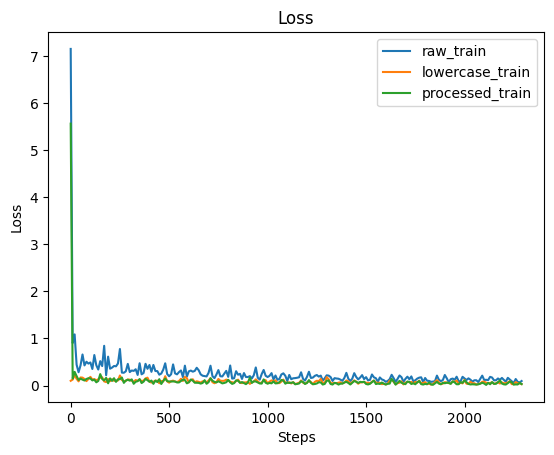

In [35]:
def plot_loss(loss_per_10_steps, dataset_name):
    # Prepare the data for plotting
    steps = [i * 10 for i in range(len(loss_per_10_steps))]

    # Plot the loss with a unique color for each dataset
    color = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot(steps, loss_per_10_steps, color=color, label=dataset_name)

# Define a list of colors for each dataset
colors = ['blue', 'green', 'red']

# Loop through the datasets
for dataset, color in zip(datasets, colors):
    # Load the saved model
    model_state_dict = torch.load(models_path + dataset + '/model.pt')
    checkpoint = torch.load(checkpoint_path + dataset + '/checkpoint.pt')

    model = T5ForConditionalGeneration.from_pretrained('t5-base', state_dict=model_state_dict, return_dict=True)
    tokenizer = T5Tokenizer.from_pretrained('t5-base')

    # Retrieve the loss_per_10_steps from the checkpoint
    loss_per_10_steps = checkpoint['loss_per_10_steps']

    # Plot the loss graph with dataset name and unique color
    plot_loss(loss_per_10_steps, dataset)

# Set the plot title, labels, and legend
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

### Testing the Model

In this code, the input_text remains the same for all datasets. It iterates over the datasets list and loads the corresponding saved model and tokenizer. It then performs the encoding, generation, and decoding steps for each dataset, printing the decoded output.

In [65]:
input_text = "Russia | leader | Putin"

for dataset in datasets:
    # Load the saved model and tokenizer for the dataset
    model_state_dict = torch.load(models_path + dataset + '/model.pt')
    tokenizer = T5Tokenizer.from_pretrained('t5-base')

    model = T5ForConditionalGeneration.from_pretrained('t5-base', state_dict=model_state_dict, return_dict=True)
    model = model.to(dev)
    model.eval()

    # Encode the input text
    input_ids = tokenizer.encode(input_text, return_tensors="pt")  # Batch size 1
    input_ids = input_ids.to(dev)

    # Generate the output
    outputs = model.generate(input_ids)
    decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Print the decoded output
    print(f"Dataset: {dataset}")
    print(decoded_output)
    print()

Dataset: raw_train
["Putrajah is Russia's leader.", 'The leader of

Dataset: lowercase_train
['Putrajaylor is a leader in Russia.', '

Dataset: processed_train
The leader of Russia is Putin., Putin is the leader of Russia., Turkey



In [77]:
def make_prediction(model_path, dataset, input_text):
    # Load the saved model and tokenizer for the dataset
    model_state_dict = torch.load(models_path + dataset + '/model.pt')
    tokenizer = T5Tokenizer.from_pretrained('t5-base')

    model = T5ForConditionalGeneration.from_pretrained('t5-base', state_dict=model_state_dict, return_dict=True)
    model = model.to(dev)
    model.eval()

    # Encode the input text
    input_ids = tokenizer.encode(input_text, return_tensors="pt")  # Batch size 1
    input_ids = input_ids.to(dev)

    # Generate the output
    outputs = model.generate(input_ids)
    decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Print the decoded output
    print(f"Dataset: {dataset}")
    print(decoded_output)
    print()


# Example usage
input_text = "Malta | schools | Andrew"
for dataset in datasets:
    make_prediction(models_path, dataset, input_text)

Dataset: raw_train
['Andrew Mitchell is a school in Malta.', 'Andre

Dataset: lowercase_train
['Andrew Andrews is the school of Andrews.', 'And

Dataset: processed_train
Andrews is a school in Malta., The school of Malta is Andrews.



#**Evaluating the model**


In [79]:
datasets = ['raw_train', 'lowercase_train', 'processed_train']

raw_dev_data_pred = []

for dataset in datasets:
    model_path = models_path + f"{dataset}/model.pt"

    # Getting the inputs (input_text) from the dataset
    dev_data_inputs = [x.replace('[','').replace(']','') for x in dev_data['input_text'].values.tolist()]

    # Feeding the input into the model and getting the predictions
    for input_text in dev_data_inputs:
        prediction = make_prediction(model_path, dev_dataset, input_text)
        dev_data_pred.append(prediction)

# Loading the reference values from the target_text column
raw_dev_data_ref = [x.replace('[','').replace(']','') for x in raw_dev_data['target_text'].values.tolist()]

FileNotFoundError: ignored

In [89]:

models_path

models_path + dataset + '/model.pt'

'/content/drive/My Drive/webNLG/project/models/'

In [82]:
## Creating both files for the ref and hypothesis as requested by the eval
import os
import locale
locale.getpreferredencoding = lambda: "UTF-8"

file_path_ref = 'raw_dev_ref.txt'
file_path_hypo = 'raw_dev_hyp.txt'

# Create or overwrite the files
with open(file_path_ref, 'w', encoding='utf-8') as f:
    for row in raw_dev_data_ref:
        f.write(row + '\n')

with open(file_path_hypo, 'w', encoding='utf-8') as f:
    for row in raw_dev_data_pred:
        f.write(row + '\n')

NameError: ignored

#### Installing dependencies for eval

In [ ]:
import shutil

def clone_and_install(repo_url):
    # Clone the repository
    subprocess.run(['git', 'clone', repo_url])

    # Set the source and target folders
    source_folder = '2023-Challenge/evaluation/automatic/scripts'
    target_folder = os.getcwd()

    # Move the contents of the source folder to the target folder
    items = os.listdir(source_folder)
    for item in items:
        source_path = os.path.join(source_folder, item)
        target_path = os.path.join(target_folder, item)
        shutil.move(source_path, target_path)

    # Delete the cloned repository folder
    shutil.rmtree('2023-Challenge')

    # Change directory to the target folder
    os.chdir(target_folder)

    # Run the install_dependencies.sh script
    subprocess.run(['sh', 'install_dependencies.sh'])

Cloning into '2023-Challenge'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (220/220), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 220 (delta 104), reused 124 (delta 43), pack-reused 0
Receiving objects: 100% (220/220), 7.67 MiB | 3.35 MiB/s, done.
Resolving deltas: 100% (104/104), done.
/content/2023-Challenge/evaluation/automatic/scripts
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 46.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 8.8 MB/s eta 0:00:00
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434677 sha256=7f579b831c981af20b56e77e47de269027f88c737c0e831c87754f17dbeee8e2
  Stored in directory: /root/.cache/pip/wheels/35/ab/82/f9667f6f884d272670a15382599a9c753a1dfdc83f7412e37d
Successfully built nltk
  Attempting uninstall: tab

In [ ]:
repo_url = 'https://github.com/WebNLG/2023-Challenge.git'
clone_and_install(repo_url)

In [ ]:
!pip install meteor pyter3 bert_score razdel tabulate sacrebleu -qqq

In [ ]:
def evaluate_datasets(model_path, datasets):
    evaluation_results = []

    for dataset in datasets:
        file_prefix = dataset + '_dev'
        file_path_ref = file_prefix + '_ref.txt'
        file_path_hypo = file_prefix + '_hyp.txt'

        # Perform evaluation
        evaluation = !python3 eval.py -hyp {file_path_hypo} -ref {file_path_ref} -nr 1 -m bleu,meteor,bert,chrf++,ter -lng en
        evaluation_results.append(evaluation[-3:])

    return evaluation_results

# Define the list of datasets
datasets = ['raw', 'lowercase', 'processed']

# Evaluate the datasets and save the results
evaluation_results = evaluate_datasets(model_path, datasets)

# Display the evaluation results
for dataset, evaluation_result in zip(datasets, evaluation_results):
    print(f"Dataset: {dataset}")
    print(evaluation_result)
    print()

In [ ]:
raw_data_eval_df = raw_data_eval[-3:]
raw_data_eval_df